100%|██████████| 300/300 [00:04<00:00, 67.72it/s]


Optimal interface x = 0.362614

Snell validation:
θ1 = 53.7257 deg
θ2 = 32.5129 deg
n1*sinθ1 = 0.806193
n2*sinθ2 = 0.806233

Segment lengths:
A -> P: 1.6901828258058804
P -> B: 1.1858585125183103


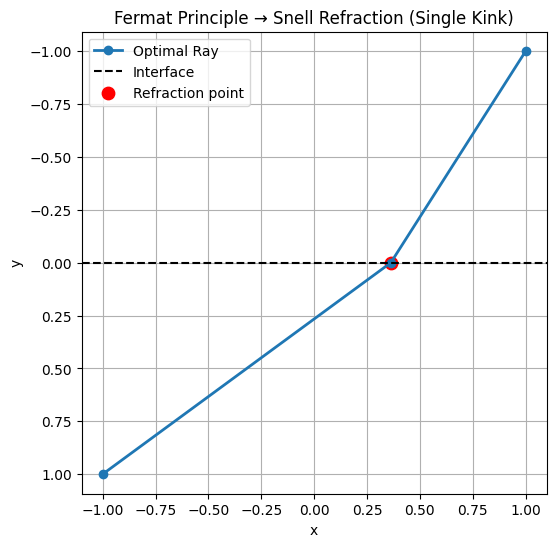

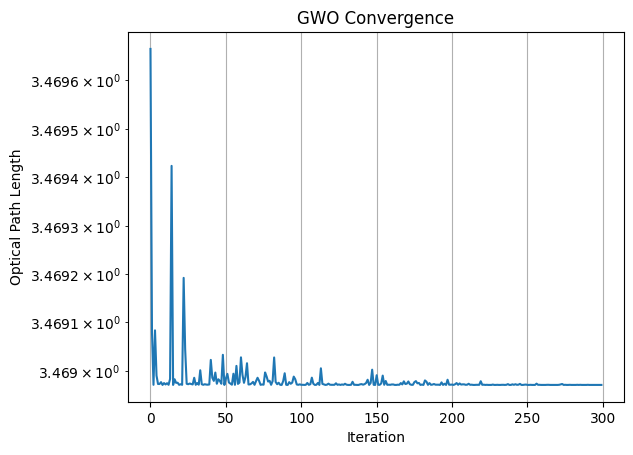

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from GWO.GWO_optimizer import GWOOptimizer  

# -----------------------------
# PHYSICAL PARAMETERS
# -----------------------------
n1 = 1.0
n2 = 1.5
y_interface = 0.0

A = np.array([-1.0,  1.0])
B = np.array([ 1.0, -1.0])

population = 40
iterations = 300
device = "cuda" if torch.cuda.is_available() else "cpu"

# -----------------------------
# OBJECTIVE FUNCTION
# -----------------------------
def optical_path(x):
    """
    x: tensor shape [1]
    """
    xr = x[0]
    P = torch.tensor([xr, y_interface], device=device)

    A_t = torch.tensor(A, device=device)
    B_t = torch.tensor(B, device=device)

    L1 = torch.norm(P - A_t)
    L2 = torch.norm(B_t - P)

    return n1 * L1 + n2 * L2 # Optical path length

# -----------------------------
# BOUNDS (x of refraction point)
# -----------------------------
bounds = [(A[0], B[0])]

# -----------------------------
# OPTIMIZER
# -----------------------------
optimizer = GWOOptimizer(
    objective_function=optical_path,
    bounds=bounds,
    population_size=population,
    max_iter=iterations,
    device=device
)

best_solution, loss_curve = optimizer.optimize()
xr = best_solution[0].item()

print(f"\nOptimal interface x = {xr:.6f}")

# -----------------------------
# RECONSTRUCT PATH
# -----------------------------
P = np.array([xr, y_interface])
pts = np.array([A, P, B])

# -----------------------------
# COMPUTE ANGLES FOR SNELL VALIDATION
# -----------------------------
v_incident  = P - A
v_refracted = B - P
normal = np.array([0.0, 1.0])

def angle_with_normal(v):
    return np.degrees(
        np.arccos(
            np.clip(
                abs(np.dot(v, normal)) / np.linalg.norm(v),
                0.0, 1.0
            )
        )
    )

theta1 = angle_with_normal(v_incident)
theta2 = angle_with_normal(v_refracted)

print("\nSnell validation:")
print(f"θ1 = {theta1:.4f} deg")
print(f"θ2 = {theta2:.4f} deg")
print(f"n1*sinθ1 = {n1*np.sin(np.radians(theta1)):.6f}")
print(f"n2*sinθ2 = {n2*np.sin(np.radians(theta2)):.6f}")

# -----------------------------
# SEGMENT LENGTHS
# -----------------------------
print("\nSegment lengths:")
print("A -> P:", np.linalg.norm(P - A))
print("P -> B:", np.linalg.norm(B - P))

# -----------------------------
# RAY PLOT
# -----------------------------
plt.figure(figsize=(6,6))

plt.plot(pts[:,0], pts[:,1], "-o", linewidth=2, label="Optimal Ray")

plt.axhline(y_interface, linestyle="--", color="black", label="Interface")

plt.scatter(P[0], P[1], c="red", s=80, label="Refraction point")

plt.xlabel("x")
plt.ylabel("y")
plt.title("Fermat Principle → Snell Refraction (Single Kink)")
plt.legend()
plt.axis("equal")
plt.gca().invert_yaxis()
plt.grid(True)
plt.show()

# -----------------------------
# CONVERGENCE PLOT
# -----------------------------
plt.figure()
plt.plot(loss_curve)
plt.yscale("log")
plt.xlabel("Iteration")
plt.ylabel("Optical Path Length")
plt.title("GWO Convergence")
plt.grid(True)
plt.show()
